## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [42]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [43]:
train, test = keras.datasets.cifar10.load_data()

In [44]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [50]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [54]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10,
              num_neurons=[512, 256, 128],
              l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """

    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])


    return model

In [55]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
Dropout_EXP = 0.25

In [56]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, drp_ratio=Dropout_EXP)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (B

196/196 [==============================] - 4s 18ms/step - loss: 1.6546 - accuracy: 0.4517 - val_loss: 1.8442 - val_accuracy: 0.3854
Epoch 46/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6652 - accuracy: 0.4423 - val_loss: 1.7416 - val_accuracy: 0.4008
Epoch 47/50
196/196 [==============================] - 4s 18ms/step - loss: 1.6782 - accuracy: 0.4380 - val_loss: 1.6807 - val_accuracy: 0.4362
Epoch 48/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6653 - accuracy: 0.4432 - val_loss: 1.6969 - val_accuracy: 0.4363
Epoch 49/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6490 - accuracy: 0.4489 - val_loss: 1.6304 - val_accuracy: 0.4530
Epoch 50/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6519 - accuracy: 0.4469 - val_loss: 1.5924 - val_accuracy: 0.4729
Experiment with Regulizer = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 O

196/196 [==============================] - 4s 18ms/step - loss: 1.4950 - accuracy: 0.5110 - val_loss: 1.5402 - val_accuracy: 0.4945
Epoch 40/50
196/196 [==============================] - 3s 18ms/step - loss: 1.5089 - accuracy: 0.5076 - val_loss: 1.5062 - val_accuracy: 0.5052
Epoch 41/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4944 - accuracy: 0.5111 - val_loss: 1.5508 - val_accuracy: 0.4933
Epoch 42/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4993 - accuracy: 0.5065 - val_loss: 1.4995 - val_accuracy: 0.5055
Epoch 43/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4854 - accuracy: 0.5157 - val_loss: 1.4877 - val_accuracy: 0.5137
Epoch 44/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4769 - accuracy: 0.5150 - val_loss: 1.5452 - val_accuracy: 0.4919
Epoch 45/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4697 - accuracy: 0.5180 - val_loss: 1.5189 - val_accuracy: 0.5071
Epoc

196/196 [==============================] - 3s 17ms/step - loss: 1.3760 - accuracy: 0.5090 - val_loss: 1.3589 - val_accuracy: 0.5165
Epoch 34/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3750 - accuracy: 0.5057 - val_loss: 1.3725 - val_accuracy: 0.5173
Epoch 35/50
196/196 [==============================] - 3s 18ms/step - loss: 1.3683 - accuracy: 0.5119 - val_loss: 1.3724 - val_accuracy: 0.5105
Epoch 36/50
196/196 [==============================] - 3s 18ms/step - loss: 1.3632 - accuracy: 0.5095 - val_loss: 1.3951 - val_accuracy: 0.4988
Epoch 37/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3705 - accuracy: 0.5099 - val_loss: 1.4122 - val_accuracy: 0.5027
Epoch 38/50
196/196 [==============================] - 3s 18ms/step - loss: 1.3656 - accuracy: 0.5070 - val_loss: 1.3717 - val_accuracy: 0.5101
Epoch 39/50
196/196 [==============================] - 3s 18ms/step - loss: 1.3438 - accuracy: 0.5145 - val_loss: 1.3795 - val_accuracy: 0.5081
Epoc

196/196 [==============================] - 3s 17ms/step - loss: 1.4384 - accuracy: 0.4834 - val_loss: 1.4152 - val_accuracy: 0.4965
Epoch 28/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4319 - accuracy: 0.4837 - val_loss: 1.4017 - val_accuracy: 0.4913
Epoch 29/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4161 - accuracy: 0.4889 - val_loss: 1.4256 - val_accuracy: 0.4781
Epoch 30/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4232 - accuracy: 0.4893 - val_loss: 1.3949 - val_accuracy: 0.5017
Epoch 31/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4053 - accuracy: 0.4952 - val_loss: 1.4102 - val_accuracy: 0.4948
Epoch 32/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4005 - accuracy: 0.4957 - val_loss: 1.4076 - val_accuracy: 0.4889
Epoch 33/50
196/196 [==============================] - 4s 18ms/step - loss: 1.3817 - accuracy: 0.5023 - val_loss: 1.3778 - val_accuracy: 0.5091
Epoc

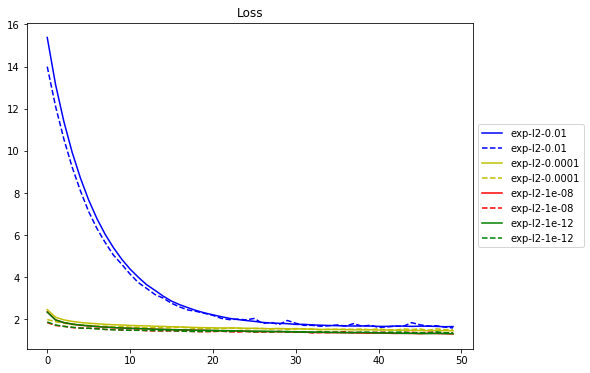

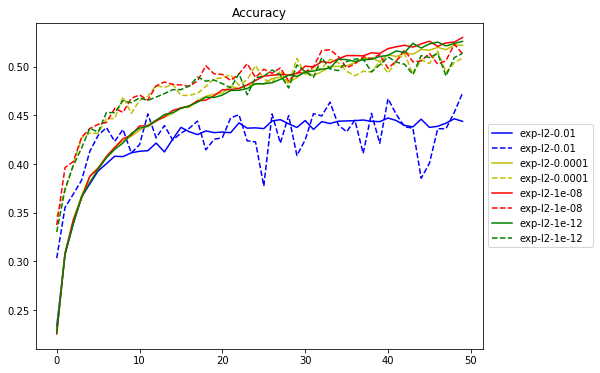

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

"""
Plot results
"""
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
#color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
color_bar = ["b","y","r","g"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()